In [ ]:
# References

# https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb

# https://github.com/spro/practical-pytorch/issues/54

In [1]:
import unicodedata
import string
import re
import random
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

In [3]:
USE_CUDA = True

In [4]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # Count SOS and EOS
      
    def index_words(self, sentence):
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [6]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [7]:
def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('../data/%s-%s.txt' % (lang1, lang2)).read().strip().split('\n')
    
    # Split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs

In [8]:
MAX_LENGTH = 10

good_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re "
)

def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(good_prefixes)

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

In [9]:
def prepare_data(lang1_name, lang2_name, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1_name, lang2_name, reverse)
    print("Read %s sentence pairs" % len(pairs))
    
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    print("Indexing words...")
    for pair in pairs:
        input_lang.index_words(pair[0])
        output_lang.index_words(pair[1])

    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data('eng', 'fra', True)

# Print an example pair
print(random.choice(pairs))

Reading lines...
Read 145437 sentence pairs
Trimmed to 9509 sentence pairs
Indexing words...
['il est innocent .', 'he s innocent .']


In [10]:
# Return a list of indexes, one for each word in the sentence
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def variable_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    var = Variable(torch.LongTensor(indexes).view(-1, 1))
#     print('var =', var)
    if USE_CUDA: var = var.cuda()
    return var

def variables_from_pair(pair):
    input_variable = variable_from_sentence(input_lang, pair[0])
    target_variable = variable_from_sentence(output_lang, pair[1])
    return (input_variable, target_variable)

In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, word_inputs, hidden):
        # Note: we run this all at once (over the whole input sequence)
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

In [23]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size, max_length=MAX_LENGTH):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        seq_len = len(encoder_outputs)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(seq_len)) # B x 1 x S
        if USE_CUDA: attn_energies = attn_energies.cuda()

        # Calculate energies for each encoder output
        for i in range(seq_len):
            attn_energies[i] = self.score(hidden, encoder_outputs[i])

        # Normalize energies to weights in range 0 to 1, resize to 1 x 1 x seq_len
        return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)
    
    def score(self, hidden, encoder_output):
        
        if self.method == 'dot':
            energy = torch.dot(hidden.view(-1), encoder_output.view(-1))
            return energy
        
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = torch.dot(hidden.view(-1), energy.view(-1))
            return energy
        
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = torch.dot(self.other.view(-1), energy.view(-1))
            return energy

In [24]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        # Keep parameters for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size * 2, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)
    
    def forward(self, word_input, last_context, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        
        # Combine embedded input word and last context, run through RNN
        rnn_input = torch.cat((word_embedded, last_context.unsqueeze(0)), 2)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs; apply to encoder outputs
        attn_weights = self.attn(rnn_output.squeeze(0), encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        
        # Final output layer (next word prediction) using the RNN hidden state and context vector
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)))
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, context, hidden, attn_weights

In [25]:
encoder_test = EncoderRNN(10, 10, 2)
decoder_test = AttnDecoderRNN('general', 10, 10, 2)
print(encoder_test)
print(decoder_test)

encoder_hidden = encoder_test.init_hidden()
word_input = Variable(torch.LongTensor([1, 2, 3]))
if USE_CUDA:
    encoder_test.cuda()
    word_input = word_input.cuda()
encoder_outputs, encoder_hidden = encoder_test(word_input, encoder_hidden)

word_inputs = Variable(torch.LongTensor([1, 2, 3]))
decoder_attns = torch.zeros(1, 3, 3)
decoder_hidden = encoder_hidden
decoder_context = Variable(torch.zeros(1, decoder_test.hidden_size))

if USE_CUDA:
    decoder_test.cuda()
    word_inputs = word_inputs.cuda()
    decoder_context = decoder_context.cuda()

for i in range(3):
    decoder_output, decoder_context, decoder_hidden, decoder_attn = decoder_test(word_inputs[i], decoder_context, decoder_hidden, encoder_outputs)
    print(decoder_output.size(), decoder_hidden.size(), decoder_attn.size())
    decoder_attns[0, i] = decoder_attn.squeeze(0).cpu().data

EncoderRNN (
  (embedding): Embedding(10, 10)
  (gru): GRU(10, 10, num_layers=2)
)
AttnDecoderRNN (
  (embedding): Embedding(10, 10)
  (gru): GRU(20, 10, num_layers=2, dropout=0.1)
  (out): Linear (20 -> 10)
  (attn): Attn (
    (attn): Linear (10 -> 10)
  )
)
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])


In [36]:
teacher_forcing_ratio = 0.5
clip = 5.0

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):

    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Get size of input and target sentences
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    # Run words through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    # Choose whether to use teacher forcing
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        
        # Teacher forcing: Use the ground-truth target as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di] # Next target is next input

    else:
        # Without teacher forcing: use network's own prediction as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            
            # Get most likely word index (highest value) from output
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            
            decoder_input = Variable(torch.LongTensor([[ni]])) # Chosen word is next input
            if USE_CUDA: decoder_input = decoder_input.cuda()

            # Stop at end of sentence (not necessary when using known targets)
            if ni == EOS_token: break

    # Backpropagation
    loss.backward()
    torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0] / target_length

In [37]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [38]:
attn_model = 'general'
hidden_size = 500
n_layers = 2
dropout_p = 0.05

# Initialize models
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers)
decoder = AttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers, dropout_p=dropout_p)

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# Initialize optimizers and criterion
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [39]:
# Configuring training
n_epochs = 50000
plot_every = 200
print_every = 1000

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

In [40]:
# Begin!
for epoch in range(1, n_epochs + 1):
    
    # Get training data for this cycle
    training_pair = variables_from_pair(random.choice(pairs))
    input_variable = training_pair[0]
    target_variable = training_pair[1]

    # Run the train function
    loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss

    if epoch == 0: continue

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

1m 10s (- 57m 22s) (1000 2%) 3.2031
2m 25s (- 58m 6s) (2000 4%) 2.8455
3m 39s (- 57m 19s) (3000 6%) 2.6248
4m 53s (- 56m 16s) (4000 8%) 2.5058
6m 7s (- 55m 6s) (5000 10%) 2.3970
7m 23s (- 54m 11s) (6000 12%) 2.2888
8m 38s (- 53m 4s) (7000 14%) 2.1936
9m 54s (- 52m 1s) (8000 16%) 2.0264
11m 10s (- 50m 54s) (9000 18%) 2.0025
12m 26s (- 49m 46s) (10000 20%) 1.8338
13m 41s (- 48m 34s) (11000 22%) 1.7982
14m 56s (- 47m 19s) (12000 24%) 1.7696
16m 11s (- 46m 5s) (13000 26%) 1.7180
17m 27s (- 44m 53s) (14000 28%) 1.6175
18m 45s (- 43m 45s) (15000 30%) 1.5746
20m 0s (- 42m 31s) (16000 32%) 1.5540
21m 16s (- 41m 17s) (17000 34%) 1.5307
22m 31s (- 40m 2s) (18000 36%) 1.3909
23m 49s (- 38m 52s) (19000 38%) 1.4005
25m 5s (- 37m 38s) (20000 40%) 1.2719
26m 21s (- 36m 23s) (21000 42%) 1.3184
27m 37s (- 35m 9s) (22000 44%) 1.3037
28m 52s (- 33m 54s) (23000 46%) 1.2313
30m 9s (- 32m 40s) (24000 48%) 1.2227
31m 25s (- 31m 25s) (25000 50%) 1.1744
32m 41s (- 30m 10s) (26000 52%) 1.1326
33m 59s (- 28m 56s

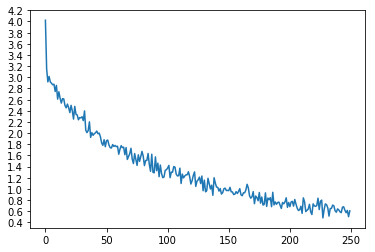

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

In [42]:
def evaluate(sentence, max_length=MAX_LENGTH):
    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    
    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([[SOS_token]])) # SOS
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([[ni]]))
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

In [43]:
def evaluate_randomly():
    pair = random.choice(pairs)
    
    output_words, decoder_attn = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    
    print('>', pair[0])
    print('=', pair[1])
    print('<', output_sentence)
    print('')

In [45]:
evaluate_randomly()

> j attends que la lumiere change .
= i m waiting for the light to change .
< i m waiting for the to the . . <EOS>



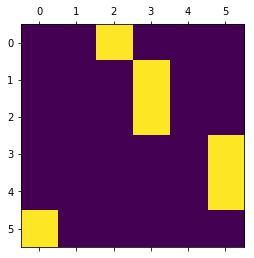

In [46]:
output_words, attentions = evaluate("je suis trop froid .")
plt.matshow(attentions.numpy())

In [47]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

def evaluate_and_show_attention(input_sentence):
    output_words, attentions = evaluate(input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    show_attention(input_sentence, output_words, attentions)

input = elle a cinq ans de moins que moi .
output = she s five years younger than me . <EOS>


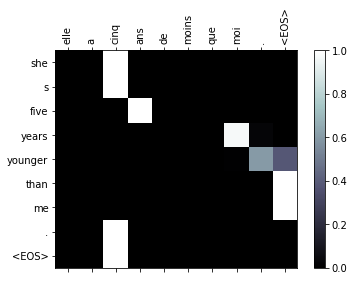

In [48]:
evaluate_and_show_attention("elle a cinq ans de moins que moi .")

input = elle est trop petit .
output = she s too loud . <EOS>


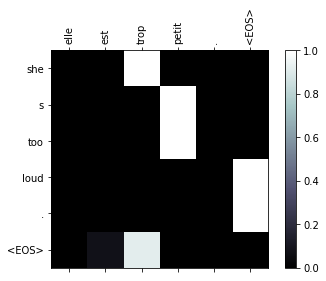

In [49]:
evaluate_and_show_attention("elle est trop petit .")

input = je ne crains pas de mourir .
output = i m afraid of dying . <EOS>


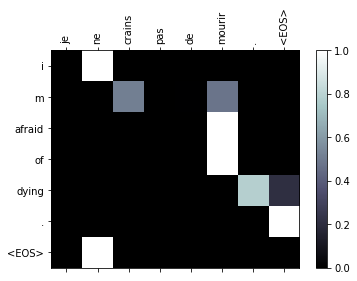

In [50]:
evaluate_and_show_attention("je ne crains pas de mourir .")

input = c est un jeune directeur plein de talent .
output = he s a young young . <EOS>


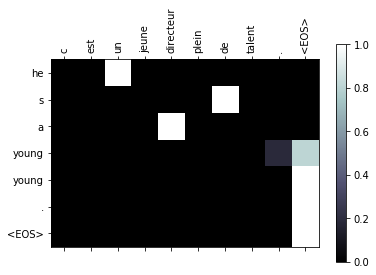

In [51]:
evaluate_and_show_attention("c est un jeune directeur plein de talent .")